In [1]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
%load_ext autoreload
%autoreload 2

In [2]:
key=True

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"

In [4]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [5]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [6]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= 3) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [7]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [8]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [9]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [10]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [11]:
file_path1 = 'embed/' + dataset_path + '/u_prime_CNNBiLSTM_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_CNNBiLSTM_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_CNNBiLSTM_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [12]:
print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

torch.Size([12840, 1, 200]) torch.Size([3400, 1, 200]) torch.Size([1462, 1, 200])


In [13]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

<h4> Creating "SAMPLE" graph features based on various graph networks

In [14]:
# len(rangesTrain)

Start of sample

<h5>DGCN

In [15]:
class SampleDataset(Dataset):
    def __init__(self):
        self.features = [torch.rand(14, 200)]
        self.edge_index = [torch.randint(0, 14, (2, 69))]
        self.edge_type = [torch.randint(0, 4, (69,))]
        self.edge_index_lengths = [torch.tensor([69])]
        self.umask = [torch.randint(0, 2, (1, 14))]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return (self.features[idx], self.edge_index[idx], self.edge_type[idx], self.edge_index_lengths[idx], self.umask[idx])

# Create the dataset and dataloader
dataset = SampleDataset()
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [16]:
# D_m = 200
# D_g = 100
# D_p = 100
# D_e = 100
# D_h = 100
# D_a = 100
# graph_hidden_size = 64
# n_speakers = 2
# max_seq_len = 110
# window_past = 0
# window_future = 5
# n_classes = 7
# dropout_rec = 0.5
# dropout = 0.5
nodal_attention = True
avec = False
no_cuda = False

features = torch.randn(14, 200)
edge_index = [torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
                            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]])]
edge_type = [torch.tensor([1, 0, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 2, 2])]
seq_lengths  = torch.tensor([[14]])
umask = torch.ones(1, 1, 14)

nodal_attn = False
avec = False

# Initialize the model
model = GraphNetwork_RGCN(num_features=200, num_classes=7, num_relations=4, max_seq_len=14)
gcn_representation = model(features, edge_index, edge_type, seq_lengths, umask, nodal_attn, avec)
print("GCN Representation Shape:", gcn_representation.shape)

GCN Representation Shape: torch.Size([14, 64])


In [17]:
features[0].shape

torch.Size([200])

<h5>GAT w/o edge feats

In [18]:
# Example usage:
num_features = 200
num_classes = 7
num_relations = 4  # This parameter is not used with GATConv but kept for compatibility
max_seq_len = 14
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GAT(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

# Dummy inputs for testing
x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# edge_type = [torch.randint(0, num_relations, (20,))]  # Example edge types

# Forward pass
out = model(x, edge_index)
print("Output shape:", out.shape)

Output shape: torch.Size([14, 64])


In [19]:
# out

<h5>GAT with edge feats

In [20]:
num_features = 200
num_classes = 7
num_relations = 4  # Assuming edge features have 4 dimensions
max_seq_len = 14
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GAT_EdgeFeat(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

# Dummy inputs for testing
x = torch.randn((14, num_features))
edge_index = [torch.randint(0, 14, (2, 20))]
edge_attr = [torch.randn((20, num_relations))]

# Forward pass
out = model(x, edge_index, edge_attr)
print("Output shape:", out.shape)

Output shape: torch.Size([14, 64])


In [21]:
# edge_attr = torch.randint(0, 2, (20, 1)).float()  # Example binary edge features
# edge_attr

<h5>GATv2 w/o edgetype

In [22]:
num_features = 200
num_classes = 7
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GATv2(num_features, num_classes, hidden_size, num_heads, dropout, no_cuda)

# Dummy inputs for testing
x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
edge_attr = torch.randn((20, 1))  # Example edge features

# Forward pass
out = model(x, edge_index, edge_attr)
print("Output shape:", out.shape)

# Forward pass with attention weights
out, (edge_index, attention_weights) = model(x, edge_index, edge_attr, return_attention_weights=True)
print("Output shape with attention:", out.shape)
print("Attention weights shape:", attention_weights.shape)

Output shape: torch.Size([14, 64])
Output shape with attention: torch.Size([14, 64])
Attention weights shape: torch.Size([32, 1])


<h5>GATv2 with edge type

In [23]:
num_features = 200
num_classes = 7
num_relations = 4
max_seq_len = 30
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GATv2_EdgeFeat(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
edge_attr = torch.randn((20, num_relations))  # Example edge features

# Forward pass
out = model(x, edge_index, edge_attr)
print("Output shape:", out.shape)

Output shape: torch.Size([14, 64])


<h5>RGAT

In [24]:
edge_index

tensor([[12,  0,  4, 11,  2,  0,  7,  1,  2,  9,  6, 12,  2,  9,  0, 13,  9, 12,
          4, 11],
        [11,  7,  9,  8, 12,  8,  2, 12,  3,  6,  9,  3, 13,  5,  7, 12, 12,  3,
          1, 12]])

In [25]:
num_features = 200
num_classes = 7
num_relations = 3  # Example number of relations
hidden_size = 64
num_heads = 8
dropout = 0.5
edge_dim = 1  # Dimensionality of edge attributes
no_cuda = False


model = GraphNetwork_RGAT(num_features, num_classes, num_relations, hidden_size, num_heads, dropout, edge_dim, no_cuda)

# Dummy inputs for testing
x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
edge_type = torch.randint(0, num_relations, (20,))  # Example edge types
edge_attr = torch.randn((20, 1))  # Example edge features

# Forward pass
out = model(x, edge_index, edge_type=edge_type)
print("Output shape:", out.shape)

Output shape: torch.Size([14, 64])


End of sample

<h4> Encode speaker to train, test, and validation sets

In [26]:
# class GraphContextDataset(Dataset):
#     def __init__(self, rangeSet, labels, features, edge_index, edge_type, \
#                  edge_index_lengths, umask, seq_lengths):
#         self.rangeSet = rangeSet
#         self.labels = [torch.tensor(label) for label in labels]
#         self.features = [torch.tensor(feature) for feature in features]
#         self.edge_index = [torch.tensor(edge) for edge in edge_index]
#         self.edge_type = [torch.tensor(edge) for edge in edge_type]
#         self.edge_index_lengths = [torch.tensor(length) for length in edge_index_lengths]
#         self.umask = umask
#         self.seq_lengths = seq_lengths
        
#     def __len__(self):
#         return len(self.rangeSet)  # Use rangeSet for length

#     def __getitem__(self, idx):
#         startIdx, endIdx = self.rangeSet[idx]
#         return (
#             self.labels[startIdx: endIdx+1],
#             self.features[idx],
#             self.edge_index[idx],
#             self.edge_type[idx],
#             self.edge_index_lengths[idx],
#             self.umask[idx],
#             self.seq_lengths[idx]
#         )

In [27]:
# file_path1 = 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_train.pkl'
# file_path2 = 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_test.pkl'
# file_path3 = 'embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_dev.pkl'

# with open(file_path1, 'rb') as file1:
#      all_umask, \
#      all_seq_lengths,\
#      all_features, \
#      all_edge_index, \
#      all_edge_norm, \
#      all_edge_type, \
#      all_edge_index_lengths = pickle.load(file1)

# file_path2 = 'data/dump/train_labels.pkl'
# with open(file_path2, 'rb') as file2:
#     trainLabels = pickle.load(file2)

# trainDataset = GraphContextDataset(rangesTrain, trainLabels,
#                                    all_features, all_edge_index,
#                                    all_edge_type,
#                                    all_edge_index_lengths,
#                                    all_umask, all_seq_lengths)
# dataLoader = DataLoader(trainDataset, batch_size=1, shuffle=False, num_workers=4)  # Use num_workers for parallel data loading

In [28]:
def getDataLoaderAndLabels(file_path, ranges):
    with open(file_path[0], 'rb') as file:
         all_umask, \
         all_seq_lengths,\
         all_features, \
         all_edge_index, \
         all_edge_norm, \
         all_edge_type, \
         all_edge_index_lengths = pickle.load(file)

    with open(file_path[1], 'rb') as file:
        labels = pickle.load(file)

    dataset = GraphContextDataset(ranges, labels,
                                       all_features, all_edge_index,
                                       all_edge_type,
                                       all_edge_index_lengths,
                                       all_umask, all_seq_lengths)
    dataLoader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    return dataLoader, labels

file_path1 = ['embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_train.pkl', 'data/dump/' + dataset_path + '/labels_train.pkl']
file_path2 = ['embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_test.pkl' , 'data/dump/' + dataset_path + '/labels_test.pkl']
file_path3 = ['embed/' + dataset_path + '/pre_h_prime_CNNBiLSTM_dev.pkl', 'data/dump/' + dataset_path + '/labels_dev.pkl']

dataLoaderTrain, trainLabels = getDataLoaderAndLabels(file_path1, rangesTrain)
dataLoaderTest, testLabels = getDataLoaderAndLabels(file_path2, rangesTest)
dataLoaderDev, devLabels = getDataLoaderAndLabels(file_path3, rangesDev)

D:\final_yr\23-24 t2\THSST-2\ug_thesis\ER_GAT\graph_context_dataset.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.features = [torch.tensor(feature) for feature in features]
D:\final_yr\23-24 t2\THSST-2\ug_thesis\ER_GAT\graph_context_dataset.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_index = [torch.tensor(edge) for edge in edge_index]
D:\final_yr\23-24 t2\THSST-2\ug_thesis\ER_GAT\graph_context_dataset.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.edge_type = [torch.tensor(edge) for edge in edge_typ

In [30]:
def RelationEncoding(file_path, dataLoader, model, config):
    all_h_prime = []
    checkFile = os.path.isfile(file_path)
    start_time = time.time()
    i = 0
    j = 1
    for _, features_in, edge_index_in, edge_type_in, _, umask, seq_lengths_in in tqdm(dataLoader, desc="Encoding Progress", unit="batch"):
        if config == "dgcn":
            avec, no_cuda, nodal_attn = False, False, False
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            seq_lengths = torch.tensor(seq_lengths_in).view(1, 1)
            graph_representation = model(feature, [edge_index], [edge_type], seq_lengths, umask, nodal_attn, avec)
        elif config == "GATv1_noAttn":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            graph_representation = model(feature, [edge_index])
            
        elif config == "GATv1":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            num_edge_types = 8
            edge_attr = torch.zeros((edge_type.size(0), num_edge_types))
            edge_attr.scatter_(1, edge_type.view(-1, 1), 1)
            graph_representation = model(feature, [edge_index], [edge_attr])
            
        elif config == "GATv2_noAttn":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            graph_representation = model(feature, edge_index)
        
        elif config == "GATv2":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            num_edge_types = 8
            edge_attr = torch.zeros((edge_type.size(0), num_edge_types))
            edge_attr.scatter_(1, edge_type.view(-1, 1), 1)
            graph_representation = model(feature, edge_index, edge_attr)
        
        elif config == "RGAT":
            feature = features_in.squeeze(0)
            edge_index = edge_index_in.squeeze(0)
            edge_type = edge_type_in.squeeze(0)
            graph_representation = model(feature, edge_index, edge_type)
        
        all_h_prime.append(graph_representation.cpu())
        
        i = i + 1
        if i % 500 == 0 and config == "RGAT":
            pt_file_path = file_path + str(j) + ".pkl"
            with open(pt_file_path, 'wb') as file:  # Corrected the file path
                pickle.dump(all_h_prime, file)
            all_h_prime = []
            j = j + 1
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train", config)
    
    if config == "RGAT":
        pt_file_path = file_path + str(j) + ".pkl"
        with open(pt_file_path, 'wb') as file:
            pickle.dump(all_h_prime, file)
    else:
        with open(file_path, 'wb') as file:
            pickle.dump(all_h_prime, file)

In [ ]:
# features = torch.randn(14, 200)
# edge_index = [torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
#                             [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 0]])]
# edge_type = [torch.tensor([1, 0, 2, 2, 2, 0, 1, 3, 2, 2, 0, 2, 2, 2])]
# seq_lengths  = torch.tensor([[14]])
# umask = torch.ones(1, 1, 14)
# print("features: ", features.shape)
# print("edge_index.shape: ", edge_index[0].shape)
# print("edge_index: ", edge_index)
# print("edge_type.shape: ", edge_type[0].shape)
# print("edge_type: ", edge_type)
# print("seq_lengths.shape: ", seq_lengths.shape)
# print("seq_lengths: ", seq_lengths)
# print("umask.shape: ", umask.shape)
# print("umask: ", umask)

In [ ]:
# edge_type_mapping = {}

# for j in range(2):
#     for k in range(2):
#         edge_type_mapping[str(j) + str(k) + '0'] = len(edge_type_mapping)
#         edge_type_mapping[str(j) + str(k) + '1'] = len(edge_type_mapping)
# edge_type_mapping

<h5>DGCN_train

In [31]:
file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_DGCN_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_DGCN_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_DGCN_dev.pkl'

model = GraphNetwork_RGCN(num_features=200, num_classes=7, num_relations=8, max_seq_len=30)
RelationEncoding(file_path1, dataLoaderTrain, model, "dgcn")
RelationEncoding(file_path2, dataLoaderTest, model, "dgcn")
RelationEncoding(file_path3, dataLoaderDev, model, "dgcn")

# gcn_representation = model(features, edge_index, edge_type, seq_lengths, umask, nodal_attn, avec)
# print("GCN Representation Shape:", gcn_representation.shape)

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.45batch/s]


It took 24.423157691955566 seconds to encode train dgcn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:11<00:00, 50.63batch/s]


It took 11.41119384765625 seconds to encode train dgcn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:09<00:00, 29.95batch/s]

It took 9.017629146575928 seconds to encode train dgcn


<h5>GAT w/o edge_feats

reviwing the types and shape

In [32]:
# all_edge_type[0]

In [33]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# edge_attr = [torch.randn((20, num_relations))]  # Example edge features
# print("x.shape: ", x.shape)
# print("edge_index.shape: ", edge_index[0].shape)
# print("edge_attr.shape: ", edge_attr[0].shape)
# print("x: ", x)
# print("edge_index: ", edge_index)
# print("edge_attr: ", edge_attr)

In [34]:
num_features = 200
num_classes = 7
num_relations = 4  # Assuming edge features have 4 dimensions
max_seq_len = 30
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_dev.pkl'

model = GraphNetwork_GAT(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)
RelationEncoding(file_path1, dataLoaderTrain, model, "GATv1_noAttn")
RelationEncoding(file_path2, dataLoaderTest, model, "GATv1_noAttn")
RelationEncoding(file_path3, dataLoaderDev, model, "GATv1_noAttn")

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.34batch/s]


It took 27.22583794593811 seconds to encode train GATv1_noAttn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:11<00:00, 49.12batch/s]


It took 11.748422384262085 seconds to encode train GATv1_noAttn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:09<00:00, 27.64batch/s]

It took 9.770514249801636 seconds to encode train GATv1_noAttn


<h5>GAT w/ edge_feats

In [ ]:
# Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = [torch.randint(0, 14, (2, 20))]  # Example edge index with 20 edges
# edge_attr = [torch.randn((20, num_relations))]  # Example edge features
# print(edge_index[0].shape)
# print(edge_attr[0].shape)
# print(edge_index)
# print(edge_attr)

In [39]:
num_features = 200
num_classes = 7
num_relations = 8  # Assuming edge features have 4 dimensions
max_seq_len = 14
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GAT_EdgeFeat(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_edgeAttr_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_edgeAttr_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv1_edgeAttr_dev.pkl'

RelationEncoding(file_path1, dataLoaderTrain, model, "GATv1")
RelationEncoding(file_path2, dataLoaderTest, model, "GATv1")
RelationEncoding(file_path3, dataLoaderDev, model, "GATv1")

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 84.63batch/s]


It took 25.52353549003601 seconds to encode train GATv1


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:10<00:00, 54.32batch/s]


It took 10.63730525970459 seconds to encode train GATv1


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:08<00:00, 30.59batch/s]

It took 8.825482368469238 seconds to encode train GATv1


<h5>GATv2 w/o edge_feats

In [ ]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, 1))  # Example edge features
# print(x.shape)
# print(edge_index.shape)
# print(edge_attr.shape)
# print(x)
# print(edge_index)
# print(edge_attr)

In [36]:
num_features = 200
num_classes = 7
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False
model = GraphNetwork_GATv2(num_features, num_classes, hidden_size, num_heads, dropout, no_cuda)
file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_dev.pkl'

RelationEncoding(file_path1, dataLoaderTrain, model, "GATv2_noAttn")
RelationEncoding(file_path2, dataLoaderTest, model, "GATv2_noAttn")
RelationEncoding(file_path3, dataLoaderDev, model, "GATv2_noAttn")

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [00:25<00:00, 85.28batch/s]


It took 25.33076047897339 seconds to encode train GATv2_noAttn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:10<00:00, 53.22batch/s]


It took 10.841038227081299 seconds to encode train GATv2_noAttn


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:09<00:00, 29.60batch/s]

It took 9.120386123657227 seconds to encode train GATv2_noAttn


<h5>GATv2 w/ edge_feats

In [39]:
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_attr = torch.randn((20, num_relations))  # Example edge features
# print(x.shape)
# print(edge_index.shape)
# print(edge_attr.shape)

In [37]:
num_features = 200
num_classes = 7
num_relations = 8
max_seq_len = 30
hidden_size = 64
num_heads = 8
dropout = 0.5
no_cuda = False

model = GraphNetwork_GATv2_EdgeFeat(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)
file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_edgeAttr_train.pkl'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_edgeAttr_test.pkl'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_GATv2_edgeAttr_dev.pkl'

RelationEncoding(file_path1, dataLoaderTrain, model, "GATv2")
RelationEncoding(file_path2, dataLoaderTest, model, "GATv2")
RelationEncoding(file_path3, dataLoaderDev, model, "GATv2")

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.62batch/s]


It took 30.588493585586548 seconds to encode train GATv2


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:12<00:00, 46.23batch/s]


It took 12.483478784561157 seconds to encode train GATv2


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:09<00:00, 27.12batch/s]

It took 9.955040216445923 seconds to encode train GATv2


<h5> RGAT

In [41]:
# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_type = torch.randint(0, num_relations, (20,))  # Example edge types
# # edge_attr = torch.randn((20, 1))  # Example edge features
# print(edge_type.shape)
# print(edge_type)

In [38]:
num_features = 200
num_classes = 7
num_relations = 8
hidden_size = 64
num_heads = 8
dropout = 0.5
edge_dim = 1  # Dimensionality of edge attributes
no_cuda = False

model = GraphNetwork_RGAT(num_features, num_classes, num_relations, hidden_size, num_heads, dropout, edge_dim, no_cuda)
file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train'
file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_test'
file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_dev'

RelationEncoding(file_path1, dataLoaderTrain, model, "RGAT")
RelationEncoding(file_path2, dataLoaderTest, model, "RGAT")
RelationEncoding(file_path3, dataLoaderDev, model, "RGAT")

Encoding Progress: 100%|████████████████████████████████████████████████████████| 2160/2160 [01:46<00:00, 20.30batch/s]


It took 106.3809425830841 seconds to encode train RGAT


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 577/577 [00:30<00:00, 18.66batch/s]


It took 30.93975305557251 seconds to encode train RGAT


Encoding Progress: 100%|██████████████████████████████████████████████████████████| 270/270 [00:14<00:00, 19.21batch/s]

It took 14.052267789840698 seconds to encode train RGAT


In [40]:
def combinePartitionedData(file_paths, output_file_path):
    combined_data = []

    for file_path in file_paths:
        if os.path.isfile(file_path):
            try:
                with open(file_path, 'rb') as file:
                    data = pickle.load(file)
                    combined_data.extend(data)
            except (pickle.UnpicklingError, EOFError) as e:
                print(f"Error loading data from {file_path}: {e}")
            except Exception as e:
                print(f"An unexpected error occurred while processing {file_path}: {e}")
        else:
            print(f"File {file_path} does not exist and will be skipped.")

    # Save the combined data to a new pickle file
    try:
        with open(output_file_path, 'wb') as file:
            pickle.dump(combined_data, file)
    except Exception as e:
        print(f"Error saving combined data to {output_file_path}: {e}")
        return

    # Delete the original files
    for file_path in file_paths:
        if os.path.isfile(file_path):
            try:
                os.remove(file_path)
            except OSError as e:
                print(f"Error deleting file {file_path}: {e}")
        
file_paths1 = ['embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train1.pkl', 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train2.pkl', 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train3.pkl', 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train4.pkl', 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train5.pkl']
file_paths2 = ['embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_test1.pkl', 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_test2.pkl']
file_paths3 = ['embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_dev1.pkl']
output_file_path1 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_train.pkl'
output_file_path2 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_test.pkl'
output_file_path3 = 'embed/' + dataset_path + '/h_prime_CNNBiLSTM_RGAT_dev.pkl'

combinePartitionedData(file_paths1, output_file_path1)
combinePartitionedData(file_paths2, output_file_path2)
combinePartitionedData(file_paths3, output_file_path3)

end of encoding train data

In [ ]:
# # change D_m into
# D_m = 100
# D_g = 150
# D_p = 150
# D_e = 100
# D_h = 100
# D_a = 100
# graph_h=100
# seed_everything()
# model = DialogueGCN_MELDModel(
#                                D_m, D_g, D_p, D_e, D_h, D_a, graph_h,
#                                n_speakers=2,
#                                max_seq_len=110,
#                                window_past=0,
#                                window_future=5,
#                                n_classes=7,
#                                listener_state=False,
#                                context_attention='general',
#                                dropout=0.5,
#                                nodal_attention=False,
#                                no_cuda=False
#                                )
# loss_function = nn.NLLLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

In [ ]:
# # Example usage
# num_features = 200
# num_classes = 7
# num_relations = 3  # Example number of relations
# max_seq_len = 30
# hidden_size = 64
# num_heads = 8
# dropout = 0.5
# no_cuda = False

# model = GraphNetwork4WithRGAT(num_features, num_classes, num_relations, max_seq_len, hidden_size, num_heads, dropout, no_cuda)

# # Dummy inputs for testing
# x = torch.randn((14, num_features))  # Example feature matrix with 14 nodes
# edge_index = torch.randint(0, 14, (2, 20))  # Example edge index with 20 edges
# edge_type = torch.randint(0, num_relations, (20,))  # Example edge types
# edge_attr = torch.randn((20, 1))  # Example edge features

# # Forward pass
# out = model(x, edge_index, edge_type=edge_type, edge_attr=edge_attr)
# print("Output shape:", out.shape)

In [ ]:
# def train_or_eval_graph_model(model, loss_function, dataloader, epoch, cuda, optimizer=None, train=False):
#     losses, preds, labels = [], [], []
#     scores, vids = [], []
    
#     ei, et, en, el = torch.empty(0).type(torch.LongTensor), torch.empty(0).type(torch.LongTensor), torch.empty(0), []
    
#     assert not train or optimizer != None
#     if train:
#         model.train()
#     else:
#         model.eval()
        
#     seed_everything()
#     for data in dataloader:
#         if train:
#             optimizer.zero_grad()
            
#         labels, features, edge_index, edge_type, edge_index_lengths, umask, _ = data
#         print("features: ", features[0].shape)
#         print("edge_index: ", edge_index[0].shape)
# #         print(edge_norm[0].shape)
#         print("edge_type: ", edge_type[0].shape)
#         print("edge_index_lengths: ", edge_index_lengths[0])
#         print("umask: ", umask[0].shape)
#         print("-------------------------------")
#         log_prob, e_i, e_n, e_t, e_l = model(features, edge_index,
# #                                              edge_norm,
#                                              edge_type, edge_index_lengths, umask)
#         label = torch.cat([label[j][:lengths[j]] for j in range(len(label))])
#         loss = loss_function(log_prob, label)

#         ei = torch.cat([ei, e_i], dim=1)
#         et = torch.cat([et, e_t])
#         en = torch.cat([en, e_n])
#         el += e_l

#         preds.append(torch.argmax(log_prob, 1).cpu().numpy())
#         labels.append(label.cpu().numpy())
#         losses.append(loss.item())

#         if train:
#             loss.backward()
#             if args.tensorboard:
#                 for param in model.named_parameters():
#                     writer.add_histogram(param[0], param[1].grad, epoch)
#             optimizer.step()
            
#     if preds != []:
#         preds = np.concatenate(preds)
#         labels = np.concatenate(labels)
#     else:
#         return float('nan'), float('nan'), [], [], float('nan'), [], [], [], [], []
    
#     ei = ei.data.cpu().numpy()
#     et = et.data.cpu().numpy()
#     en = en.data.cpu().numpy()
#     el = np.array(el)
#     labels = np.array(labels)
#     preds = np.array(preds)

#     avg_loss = round(np.sum(losses) / len(losses), 4)
#     avg_accuracy = round(accuracy_score(labels, preds) * 100, 2)
#     avg_fscore = round(f1_score(labels, preds, average='macro') * 100, 2)
#     # Add precision and recall
#     precision = round(precision_score(labels, preds, average='macro') * 100, 2)
#     recall = round(recall_score(labels, preds, average='macro') * 100, 2)
#     return avg_loss, avg_accuracy, labels, preds, avg_fscore, ei, et, en, el, precision, recall
    
    
# for e in range(60):
#     train_loss, train_acc, _, _, _, train_fscore, _ = train_or_eval_graph_model(model, loss_function,
#                                                                           dataloader, e,
#                                                                           optimizer, True)
#     print(
#     'epoch: {}, train_loss: {}, train_acc: {}, train_fscore: {}, train_precision: {}, train_recall: {}, '. \
#     format(e + 1, train_loss, train_acc, train_fscore, train_precision, train_recall))
    

<h4> Creating graph features from Test Data (NO NEED FOR THIS SECTION)

In [45]:
# checkFile = os.path.isfile("data/dump/speaker_encoder_test.pkl")
# encodedSpeakersTest = []
# rangesTest = []

# if not checkFile:
#     print("Run first the contextEncoder2 to generate this file")
# else:
#     with open('data/dump/speaker_encoder_test.pkl', "rb") as file:
#         encodedSpeakersTest, rangesTest = pickle.load(file)

# checkFile = os.path.isfile("data/dump/adjListTest.pkl")
# adjacencyListTest = []

# if key:
#     adjacencyListTest = get_all_adjacency_list(rangesTest)
# else:
#     with open('data/dump/adjListTest', "rb") as file:
#         adjacencyListTest = pickle.load(file)

In [46]:
# file_path = 'embed/u_prime_CNNBiLSTM_test.pkl'

# # Load the list from the file using pickle
# with open(file_path, 'rb') as file:
#     contextualEmbeddingsTest = pickle.load(file)

In [47]:
# edgeIndicesTest = get_all_adjacency_list(rangesTest)
# edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
# edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

<h4> Creating graph features from Test Data

In [ ]:
# TODO repeat the one above

<h3> Get GAT output from each set of data (DISCONTINUED)

<h4> Instantiating the GAT (1st implementation) for 1 sample train data

In [36]:
# num_in_features = len(contextualEmbeddingsTrain[0][0])
# num_out_features = len(contextualEmbeddingsTrain[0][0])
# num_heads = 4
# num_edge_types = 3
# gat_layer = GATLayerWithEdgeType(num_in_features, num_out_features, num_heads, num_edge_types)

In [35]:
# i = 0  # dialogue id
# relationalEmbedding, attentionCoef = gat_layer((contextualEmbeddingsTrain[i], edgeIndicesTrain[i]), edgeTypesTrain[i])
# print("h_prime shape: ", relationalEmbedding.shape, "attention_coef shape: ", attentionCoef.shape)

# targetNodes = edgeIndicesTrain[i][1].tolist()

# sample = {}
# sampleEdgetypes = []

# for target_i in sorted(set(targetNodes)):
#     sample[target_i] = []

# for targetNode, idx in zip(targetNodes, range(len(targetNodes))):
#     sample[targetNode].append([idx, relationalEmbedding[targetNode][idx].tolist()])

# listEdgeIdxTrain, inferredEdgeTypes = get_inferred_edgetypes_GAT(sample, edgeTypesTrain[i])
# sampleEdgetypes.append(inferredEdgeTypes)

In [41]:
file = open('data/dump/' + dataset_path + '/label_decoder.pkl', 'rb')
label_decoder = pickle.load(file)
file.close()

label_decoder = list(label_decoder.values())
print(label_decoder)

['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


In [ ]:
# checkFile = os.path.isfile("data/dump/labels_train.pkl")

# if checkFile is False:
#     print("Please run the contextEncoder1 notebook to save the label file")
# else:
#     file = open('data/dump/labels_train.pkl', 'rb')
#     y_train = pickle.load(file)
#     file.close()

In [ ]:
# y_train[0:15]

In [ ]:
# checkFile = os.path.isfile("data/dump/labels_test.pkl")

# if checkFile is False:
#     print("Please run the contextEncoder2 notebook to save the label file")
# else:
#     file = open('data/dump/labels_test.pkl', 'rb')
#     y_test = pickle.load(file)
#     file.close()

<h5>Unsupervised Visualizarion

In [ ]:
# # Assuming h_prime contains the node embeddings
# utt_size = 13
# labels = torch.tensor(y_train[:utt_size + 1])

# cherrypicked_nodes = []
# for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
#     cherrypicked_nodes.append(attention_coef[src_idx, :, edge_idx].tolist())
# cherrypicked_nodes = torch.tensor(cherrypicked_nodes)


In [ ]:
# h_prime_np = cherrypicked_nodes.detach().numpy()

# # Perform dimensionality reduction using t-SNE
# tsne = TSNE(n_components=3, perplexity=5, random_state=42)
# h_prime_tsne = tsne.fit_transform(h_prime_np)

# # Plot the node embeddings with different colors for each label
# plt.figure(figsize=(10, 8))
# for label, emotion in zip(range(len(label_decoder)), label_decoder): 
#     indices = (labels == label).nonzero().squeeze()
#     plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
# plt.title('Node Embeddings Visualization (t-SNE)', color="white")
# plt.xlabel('Dimension 1', color="white")
# plt.ylabel('Dimension 2', color="white")
# plt.legend()
# plt.show()

<h4> Now get new representations of all train, test, validation

In [ ]:
# # filePath = data/dump/h_prime_BERT-GAT_train.pkl
# #            data/dump/h_prime_BERT-GAT_test.pkl
# #            data/dump/h_prime_BERT-GAT_valid.pkl

# def get_GAT_representation(filePath, contextualEmbeddings, edgeIndices, edgeTypes):
# #     checkFile = os.path.isfile("data/dump/h_prime_BERT-GAT_train.pkl") #replace it with key when deployed
#     if key:
#         print("Start of getting output of 1st GAT")
#         allInferredEdgetypes = []
#         listAllEdgeIdx = []
#         cherrypickedNodes = []
#         for dialog, dialog_id in zip(contextualEmbeddings, range(len(contextualEmbeddings))):
#             h_prime, attention_coef = gat_layer((dialog, edgeIndices[dialog_id]), edgeTypes[dialog_id])
#             target_nodes = edgeIndices[dialog_id][1].tolist() # first idx represents dialogue id

#             sample_edgetypes = {}
#             for i in set(target_nodes):
#                 sample_edgetypes[i] = []

#             for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
#                 sample_edgetypes[target_node].append([edge_idx, h_prime[target_node][edge_idx].tolist()])

#             list_edge_idx, inferred_edgetypes = get_inferred_edgetypes_GAT(sample_edgetypes,  edgeTypes[dialog_id])
#             listAllEdgeIdx.append(list_edge_idx)
#             allInferredEdgetypes.append(inferred_edgetypes)

#             for src_idx, edge_idx in zip(range(len(list_edge_idx)), list_edge_idx):
#                 cherrypickedNodes.append(attention_coef[src_idx, :, edge_idx].tolist())

#         cherrypickedNodes = torch.tensor(cherrypickedNodes)
#         cherrypickedNodes.shape
#         print("End of getting output of 1st GAT")

#         pickle.dump([cherrypickedNodes, allInferredEdgetypes],
#                     open(filePath, 'wb'))

#     else:
#         file = open(filePath, 'rb')
#         cherrypickedNodes, allInferredEdgetypes = pickle.load(file)
#         file.close()

#     return cherrypickedNodes, allInferredEdgetypes

In [ ]:
# # train data
# cherrypickedNodesTrain, allInferredEdgetypesTrain = get_GAT_representation(
#                                                     "embed/h_prime_CNNBiLSTM-GAT_train.pkl",
#                                                     contextualEmbeddingsTrain,
#                                                     edgeIndicesTrain,
#                                                     edgeTypesTrain)
# # only save the pickle data for test and validation
# _, _ = get_GAT_representation("embed/h_prime_CNNBiLSTM-GAT_test.pkl",
#                         contextualEmbeddingsTest,
#                         edgeIndicesTest,
#                         edgeTypesTest)
# # TODO add valid set

<h5> Visualize Train Data

In [101]:
# labels = torch.tensor(trainLabels)
# h_prime_np = cherrypickedNodesTrain.detach().numpy() (discontinued)

In [ ]:
# runTSNE = 0

In [ ]:
# if runTSNE:
#     # List of perplexity values to loop over
#     perplexity_values = [30, 100]

#     # Loop over each perplexity value
#     for perplexity in perplexity_values:
#         # Initialize t-SNE with the current perplexity value
#         tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

#         # Fit and transform the data using t-SNE
#         h_prime_tsne = tsne.fit_transform(h_prime_np)

#         # Plot the node embeddings with different colors for each label
#         plt.figure(figsize=(10, 8))
#         for label, emotion in zip(range(len(label_decoder)), label_decoder): 
#             indices = (labels == label).nonzero().squeeze()
#             plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
#         plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
#         plt.xlabel('Dimension 1', color="white")
#         plt.ylabel('Dimension 2', color="white")
#         plt.legend()
#         plt.show()

<h4> Analyze the edgetypes of all train nodes in the context of a dialog

In [ ]:
# # Assuming `all_inferred_edgetypes` and `y_train` are defined
# df_eda = pd.DataFrame(
#     {'edgetype': flatten_extend(allInferredEdgetypesTrain),
#      'label': y_train,
#     })

In [ ]:
# # Assuming `df_eda` and `CrosstabResult` are defined
# CrosstabResult = pd.crosstab(index=df_eda['edgetype'], columns=df_eda['label'])

# print("Crosstab Result:")
# print(CrosstabResult)
# print()

# # Performing Chi-squared test
# ChiSqResult = chi2_contingency(CrosstabResult)

# # P-Value is the Probability of H0 being True
# # If P-Value > 0.05 then only we Accept the assumption(H0)
# # H0: The variables are not correlated with each other.

# print('The P-Value of the Chi-Squared Test is:', ChiSqResult[1])

# if ChiSqResult[1] > 0.05:
#     print("Variables are not correlated with each other")
# else:
#     print("Two variables are correlated")

<h3> Get EGAT output from each set of data (train, test, validation)

In [42]:
egat = EGATConv(in_node_feats=len(contextualEmbeddingsTrain[0][0]),
                    in_edge_feats=3,
                    out_node_feats=64,
                    out_edge_feats=3,
                    num_heads=4)

In [44]:
def get_EGAT_representations(filePath, contextualEmbeddings, edgeIndices, edgeTypes, ranges):
#     checkFile = os.path.isfile("data/dump/h_prime_BERT-EGAT_train.pkl")
    if key:
#         print("Start of getting output of 2nd GAT")
        inferredEdgetypes = []
        allNodeFeats = []

        # Iterate over each dialogue
        for dialog_id in tqdm(range(len(edgeIndices)), desc="Encoding Progress", unit="batch"):
            startIdx, endIdx = ranges[dialog_id][0], ranges[dialog_id][1]
            # Create a DGL graph
            graph = dgl.graph((edgeIndices[dialog_id][0], edgeIndices[dialog_id][1]))

            # Get one-hot encoded edge features
            edge_feats = get_ohe(edgeTypes[dialog_id])

            # Get outputs from the second GAT layer
            egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)
            new_node_feats, new_edge_feats = egat_output

            # Compute mean edge features
            mean_edge_feats = new_edge_feats.mean(dim=1)
            allNodeFeats.append(new_node_feats.mean(dim=1).tolist())

            # Prepare edge features for inference
            target_nodes = edgeIndices[dialog_id][1].tolist()
            sample_edgetypes = {}
            for i in set(target_nodes):
                sample_edgetypes[i] = []
            for target_node, edge_idx in zip(target_nodes, range(len(target_nodes))):
                sample_edgetypes[target_node].append([edge_idx, 
                                                      mean_edge_feats[edge_idx].tolist()])

            # Infer edge types
            sample_edgetypes = get_inferred_edgetypes_EGAT(sample_edgetypes, edgeTypes[dialog_id], 
                                                           len(contextualEmbeddings[startIdx: endIdx+1]), 
                                                           dialog_id)
            inferredEdgetypes.append(sample_edgetypes)

        # Flatten and convert node features to tensor
        allNodeFeats = torch.tensor(flatten_extend(allNodeFeats))

#         print("End of getting output of 2nd GAT")

        # Save the data to a pickle file
        pickle.dump([allNodeFeats, inferredEdgetypes], open(filePath, 'wb'))
    else:
        # Load data from the existing pickle file
        file = open(filePath, 'rb')
        all_node_feats, inferredEdgetypes = pickle.load(file)
        file.close()

    return allNodeFeats, inferredEdgetypes

In [45]:
# tensor_squeezedTrain.shape
# torch.Size([12840, 200])

torch.Size([12840, 200])

In [73]:
# edgeTypesTrain

In [1]:
tensor_squeezedTrain = contextualEmbeddingsTrain.squeeze(1)
allNodeFeatsTrain, inferredEdgetypesTrain = get_EGAT_representations(
                                        "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_train.pkl",
                                        tensor_squeezedTrain,
                                        edgeIndicesTrain,
                                        edgeTypesTrain,
                                        rangesTrain
                                )

tensor_squeezedTest = contextualEmbeddingsTest.squeeze(1)
_, _ = get_EGAT_representations(
        "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_test.pkl",
        tensor_squeezedTest,
        edgeIndicesTest,
        edgeTypesTest, 
        rangesTest
)

tensor_squeezedDev = contextualEmbeddingsDev.squeeze(1)
_, _ = get_EGAT_representations(
        "embed/" + dataset_path + "/h_prime_CNNBiLSTM-EGAT_dev.pkl",
        tensor_squeezedDev,
        edgeIndicesDev,
        edgeTypesDev, 
        rangesDev
)

NameError: name 'contextualEmbeddingsTrain' is not defined

In [47]:
df_eda2 = pd.DataFrame(
    {'edgetype': flatten_extend(inferredEdgetypesTrain),
     'label': trainLabels,
    })

In [48]:
# Create a DataFrame from your data (df_eda2)
# Assuming df_eda2 is already defined

# Crosstabulation
CrosstabResult2 = pd.crosstab(index=df_eda2['edgetype'], columns=df_eda2['label'])
print("Crosstab Result:\n", CrosstabResult2)

# Performing Chi-squared test
ChiSqResult2 = chi2_contingency(CrosstabResult2)

# Print the p-value of the Chi-squared test
print('The P-Value of the ChiSq Test is:', ChiSqResult2[1])

# Interpret the p-value
if ChiSqResult2[1] > 0.05:
    print("Variables are not correlated with each other")
else:
    print("Two variables are correlated")


Crosstab Result:
 label        0    1    2     3     4    5     6
edgetype                                       
0         1091  258  242  1644  4347  627  1136
1          409  106   96   668  1613  249   354
The P-Value of the ChiSq Test is: 0.03080562512893102
Two variables are correlated


Testing on 1 dialog data before scaling up

In [49]:
dialog_id = 0

# Create a DGL graph
graph = dgl.graph((edgeIndicesTrain[dialog_id][0], edgeIndicesTrain[dialog_id][1]))

# Obtain one-hot encoded edge features
edge_feats = get_ohe(edgeTypesTrain[dialog_id])

# Pass the graph, node representations, and edge features through the EGAT model
tensor_squeezedTrain = contextualEmbeddingsTrain.squeeze(1)
newNodeFeats, newEdgeFeats = egat(graph, tensor_squeezedTrain[0:14], edge_feats)

# Print the shapes of the new node and edge features
print("New Node Features Shape:", newNodeFeats.shape)
print("New Edge Features Shape:", newEdgeFeats.shape)

# Calculate the mean of node features along the second dimension (number of nodes)
h_prime_mean = newNodeFeats.mean(dim=1)

# Assuming you want to select only a subset of labels for visualization
utt_size = 13
labels = torch.tensor(trainLabels[:utt_size+1])

New Node Features Shape: torch.Size([14, 4, 64])
New Edge Features Shape: torch.Size([50, 4, 3])


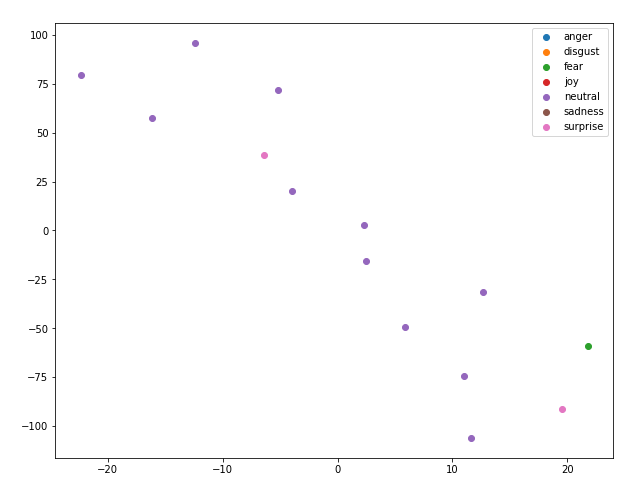

In [50]:
# Convert tensor to numpy array
h_prime_np = h_prime_mean.detach().numpy()
# Perform dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
h_prime_tsne = tsne.fit_transform(h_prime_np)

# Plot the node embeddings with different colors for each label
plt.figure(figsize=(10, 8))
for label, emotion in zip(range(len(label_decoder)), label_decoder): 
    indices = (labels == label).nonzero().squeeze()
    plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
plt.title('Node Embeddings Visualization (t-SNE)', color="white")
plt.xlabel('Dimension 1', color="white")
plt.ylabel('Dimension 2', color="white")
plt.legend()
plt.show()


In [51]:
runTSNE = 0

In [52]:
if runTSNE:
    # Convert tensor to numpy array
    h_prime_np = allNodeFeatsTrain.detach().numpy()
    labels = torch.tensor(trainLabels)
    
    # List of perplexity values to loop over
    perplexity_values = [30, 100]

    # Loop over each perplexity value
    for perplexity in perplexity_values:
        # Initialize t-SNE with the current perplexity value
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

        # Fit and transform the data using t-SNE
        h_prime_tsne = tsne.fit_transform(h_prime_np)
        print(h_prime_tsne.shape)
        
        # Plot the node embeddings with different colors for each label
        plt.figure(figsize=(10, 8))
        for label, emotion in zip(range(len(label_decoder)), label_decoder): 
            indices = (labels == label).nonzero().squeeze()
            plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
        plt.title(f'Node Embeddings Visualization (t-SNE) - Perplexity {perplexity}', color="white")
        plt.xlabel('Dimension 1', color="white")
        plt.ylabel('Dimension 2', color="white")
        plt.legend()
        plt.show()
